In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm


#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time
from scipy.special import logsumexp 

In [3]:
#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [4]:
#==========================Gaussian Target Distribution==========================
def target_pdf(x, mu=0, sigma=1):
    """
    Compute the PDF of a Gaussian distribution with mean 0 and standard deviation 1.
    """
    return 1 / (np.pi * (1+x**2))  #norm.pdf(x, mu, sigma)

def metropolis_hastings(xo, thinning, burnin, N, step_size, target_pdf):


    """
    Perform Metropolis-Hastings sampling to generate samples from a Gaussian distribution.
    
    Parameters:
    mu (float): Mean of the Gaussian distribution.
    sigma (float): Standard deviation of the Gaussian distribution.
    N (int): Number of samples to generate.
    
    Returns:
    np.ndarray: Array of samples from the Gaussian distribution.
    """
    samples = []
    x_current = xo  # Starting point
    
    for _ in range(N):
        # Propose a new sample from a normal distribution centered at the current sample
        x_proposed = x_current + rng.uniform(-step_size, step_size)
        
        # Compute acceptance ratio
        acceptance_ratio = target_pdf(x_proposed) / target_pdf(x_current) 
        
        # Accept or reject the proposed sample
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed
        
        samples.append(x_current)
    # Thinning: only keep every 'thinning'-th sample
    samples = samples[::thinning]
    # Burn-in: discard the first 'burnin' samples
    samples = samples[burnin:]
    samples = np.array(samples)
    
    return np.array(samples)

    # Generate N samples from the target distribution (standard normal) using rng

def importance_integration(f, N, rng, m_chain):
    # Compute the importance weights
    weights = f(m_chain) / target_pdf(m_chain, 0, 1.0)  # PDF of the target distribution
    estimate = np.mean(weights)  # Mean of the weights as the estimator of the integral
    
    return estimate
# Define the function f(x) = e^(-x^2)
def f(x):
    return np.exp(-x**2)

### Plot of Integral estimate vs number of samples

In [12]:
num_repeats = 10
N_values = np.logspace(2, 6, 30, dtype=int)
integral_estimates = []
std_errors = []

for N_val in N_values:
    estimates = []
    for _ in range(num_repeats):
        m_chain = metropolis_hastings(0, 1, int(0.1*N), N_val, 3, target_pdf)
        estimate = importance_integration(f, N_val, rng, m_chain)
        estimates.append(estimate)
    integral_estimates.append(np.mean(estimates))
    std_errors.append(np.std(estimates) / np.sqrt(num_repeats))

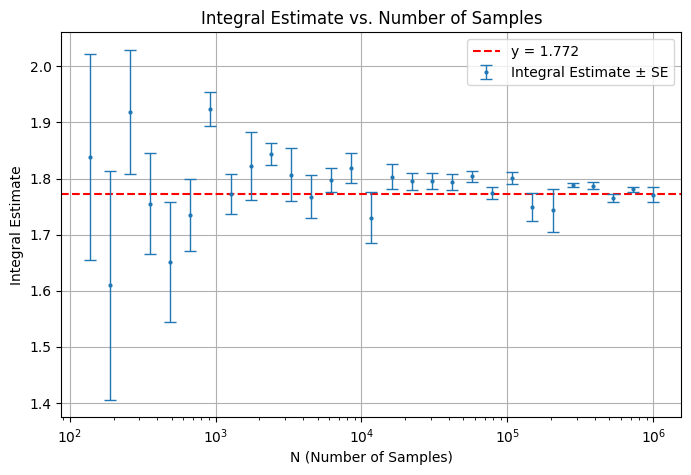

In [13]:
plt.figure(figsize=(8, 5))
plt.axhline(y=1.772, color='red', linestyle='--', label='y = 1.772')
plt.errorbar(N_values, integral_estimates, yerr=std_errors, fmt='o', markersize=2, capsize=4, elinewidth=1, capthick=1, label='Integral Estimate ± SE')
plt.xscale('log')
plt.xlabel('N (Number of Samples)')
plt.ylabel('Integral Estimate')
plt.title('Integral Estimate vs. Number of Samples')
plt.grid(True)
plt.legend()
plt.show()


### Integral value vs Acceptance rate including error bars

In [ ]:
# Explore a wider range of step sizes to include lower acceptance rates
step_sizes = np.linspace(0.1, 20.0, 25)  # Increased upper bound for lower acceptance rates
n_repeats = 10  # Number of repeated runs for error bars
N = 100_000
thinning = 1
burnin = 1000

acceptance_rates = []
mean_integrals = []
std_integrals = []

for step_size in step_sizes:
    integral_estimates = []
    acceptance_rate_runs = []
    for _ in range(n_repeats):
        m_chain = metropolis_hastings(0, thinning, burnin, N, step_size, target_pdf)
        # Calculate acceptance rate
        accepted = np.sum(np.diff(m_chain) != 0)
        acceptance_rate = accepted / len(m_chain)
        acceptance_rate_runs.append(acceptance_rate)
        # Estimate the integral
        estimate = importance_integration(f, N, rng, m_chain)
        integral_estimates.append(estimate)
    # Store mean acceptance rate and mean/std of integral estimates
    acceptance_rates.append(np.mean(acceptance_rate_runs))
    mean_integrals.append(np.mean(integral_estimates))
    std_integrals.append(np.std(integral_estimates))

plt.figure(figsize=(8, 5))
plt.errorbar(acceptance_rates, mean_integrals, yerr=std_integrals, fmt='o', markersize=4, capsize=4, label='Integral Estimate ± std')
plt.axhline(y=1.772, color='red', linestyle='--', label='y = 1.772 (reference)')
plt.xlabel('Acceptance Rate')
plt.ylabel('Integral Estimate')
plt.title('Integral Estimate vs Acceptance Rate (mean ± std over repeats)')
plt.grid(True)
plt.legend()
plt.show()

### Variance of Integral Estimate vs Acceptance Rate
This plot shows the variance (squared standard deviation) of the integral estimate as a function of acceptance rate. The optimal region is where the variance is minimized, indicating the most stable estimator.

In [ ]:
# Compute variance from std_integrals (already calculated in previous cell)
variances = np.array(std_integrals) ** 2

plt.figure(figsize=(8, 5))
plt.plot(acceptance_rates, variances, marker='o', markersize=4, label='Variance of Estimate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Variance of Integral Estimate')
plt.title('Variance vs Acceptance Rate')
plt.grid(True)
plt.legend()
plt.show()

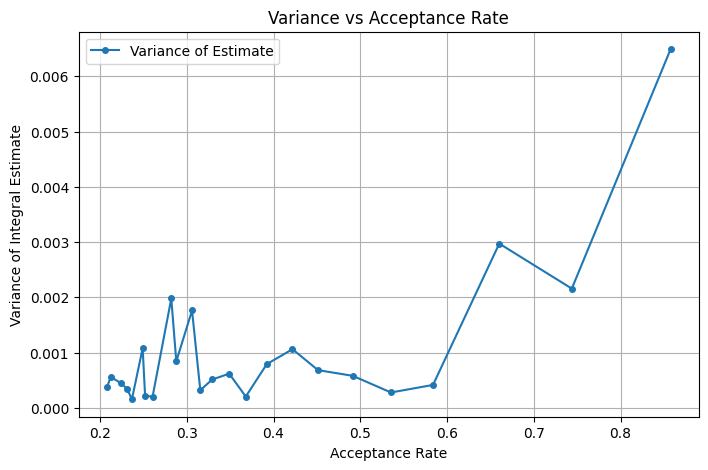

In [42]:
new_acceptance_rates = acceptance_rates[-(len(acceptance_rates) - 1):]
new_variances = variances[-(len(variances) - 1):]
plt.figure(figsize=(8, 5))
plt.plot(new_acceptance_rates, new_variances, marker='o', markersize=4, label='Variance of Estimate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Variance of Integral Estimate')
plt.title('Variance vs Acceptance Rate')
plt.grid(True)
plt.legend()
plt.show()